<a href="https://colab.research.google.com/github/Adityachauhan2344/Adityachauhan2344/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pyod
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185331 sha256=d8c63f9f896809ed63acc2d9120b8167d91271a4c54a7bb231b874447edec97f
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [2]:
#####
# Trial or epoch = eeg segment
#####

channels = 32
seconds = 0.5    # Size of each segment we want
fs = 256.0         # Dtaset eeg sampling rate
data_portion = 1
save_model = False

In [3]:
import os

# Replace 'new_directory' with the desired name of the new directory
new_directory = "../input/eeg-dataset/"

# Create the new directory in the current working directory (usually '/content/')
os.makedirs(new_directory, exist_ok=True)


In [5]:
import shutil

# Replace 'features_raw.csv' with the file name and path of the file you want to move
file_to_move = '/content/drive/MyDrive/features_raw.csv.zip'

# Replace '../input/eeg-dataset/' with the destination directory path
destination_directory = '../input/eeg-dataset/'

# Move the file to the destination directory
shutil.move(file_to_move, destination_directory)


'../input/eeg-dataset/features_raw.csv.zip'

In [7]:
df = pd.read_csv('../input/eeg-dataset/features_raw.csv.zip')
df.head()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2,Unnamed: 32
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618,NaN
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093,NaN
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537,NaN
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060,NaN
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816,NaN


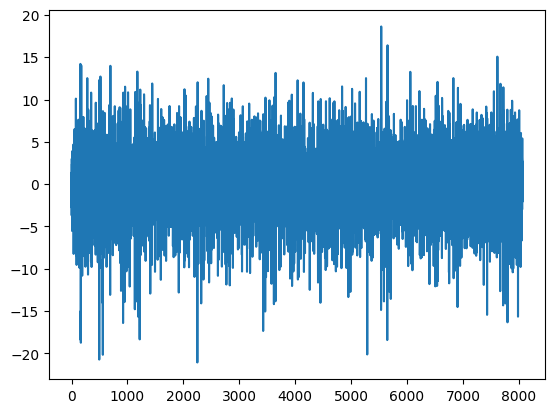

In [8]:
plt.plot(df['Fp1'])

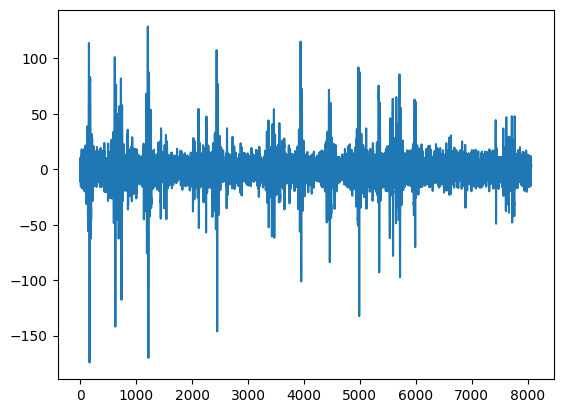

In [9]:
plt.plot(df['AF3'])

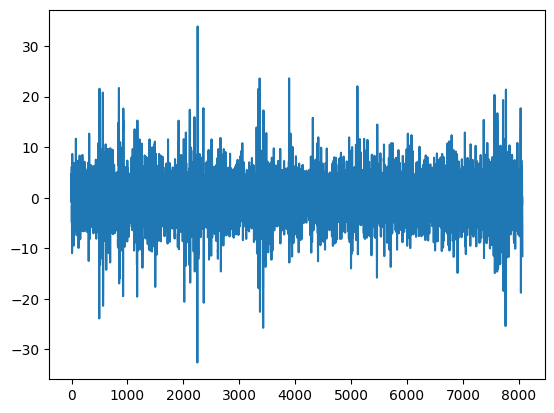

In [10]:
plt.plot(df['F3'])

In [11]:
class EEGDataset2:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'

        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion

    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]

        if self.normalize:
            df = (df - df.mean()) / df.std()

        if self.isolated_channels:
            channels = []
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)

        dataset = []

        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())

        return np.array(dataset)

In [13]:
train_csv = '../input/eeg-dataset/features_raw.csv.zip'
eegDataset = EEGDataset2(train_csv, seconds, fs, data_portion, normalize=True)

train_dataset = eegDataset.get_data()

In [14]:
train_dataset.shape

(2016, 128)

In [15]:
clf = hbos.HBOS(n_bins=17, alpha=0.07, tol=0.5,contamination=.15)
clf.fit(train_dataset)

print("="*20)
print("TRAINING THE MODEL")

TRAINING THE MODEL


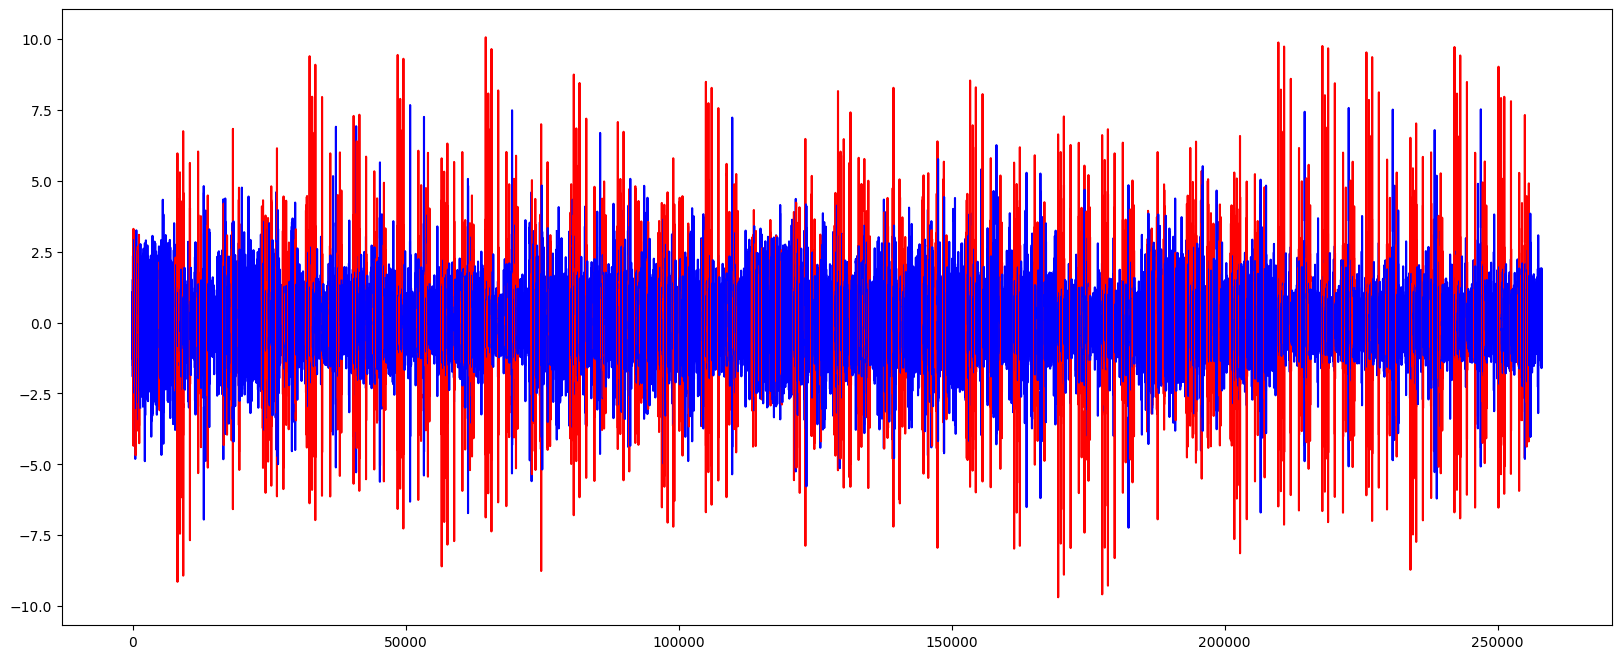

In [16]:
pred = clf.predict(train_dataset)

for i in range(len(pred)):
    plt.rcParams["figure.figsize"] = (20,8)

    if pred[i] == 1: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='red')
    else: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='b')

In [19]:

!pip install --upgrade scikit-learn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()
from sklearn.metrics import plot_confusion_matrix
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


ImportError: ignored

In [1]:
import os

# Replace 'new_directory' with the desired name of the new directory
new_directory = "../input/eeg-brainwave-dataset-feeling-emotions/"

# Create the new directory in the current working directory (usually '/content/')
os.makedirs(new_directory, exist_ok=True)

In [3]:
import shutil

# Replace 'features_raw.csv' with the file name and path of the file you want to move
file_to_move = "/content/drive/MyDrive/emotions.csv.zip"

# Replace '../input/eeg-dataset/' with the destination directory path
destination_directory = "../input/eeg-brainwave-dataset-feeling-emotions/"

# Move the file to the destination directory
shutil.move(file_to_move, destination_directory)

'../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv.zip'

In [6]:
import pandas as pd

data = pd.read_csv("../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv.zip")

In [7]:
len(data)

2132

In [13]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [14]:
x_train.shape[1]

2548

In [17]:
import tensorflow as tf

def create_model():
    #input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #Hidden Layer for Brain signal using LSTM(GRU)
    expand_dims = tf.expand_dims(inputs, axis=2)

    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    #Flatten Gru layer into vector form (one Dimensional array)
    flatten = tf.keras.layers.Flatten()(gru)
    #output latyer of Model
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [18]:
#cretaing model
lstmmodel = create_model()
#Compiling model
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2548)]            0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2548, 1)          0         
                                                                 
 gru (GRU)                   (None, 2548, 256)         198912    
                                                                 
 flatten (Flatten)           (None, 652288)            0         
                                                                 
 dense (Dense)               (None, 3)                 1956867   
                                                                 
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
#Training and Evaluting model
history = lstmmodel.fit(x_train, y_train, epochs = 10, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)

Epoch 1/10
48/48 [==============================] - 374s 8s/step - loss: 0.6219 - accuracy: 0.8644 - val_loss: 0.3036 - val_accuracy: 0.8889
Epoch 2/10
48/48 [==============================] - 364s 8s/step - loss: 0.1586 - accuracy: 0.9374 - val_loss: 0.2317 - val_accuracy: 0.9006
Epoch 3/10
48/48 [==============================] - 365s 8s/step - loss: 0.1794 - accuracy: 0.9316 - val_loss: 0.2106 - val_accuracy: 0.9240
Epoch 4/10
48/48 [==============================] - 364s 8s/step - loss: 0.1069 - accuracy: 0.9615 - val_loss: 0.1915 - val_accuracy: 0.9591
Epoch 5/10
48/48 [==============================] - 367s 8s/step - loss: 0.0432 - accuracy: 0.9876 - val_loss: 0.2855 - val_accuracy: 0.9415
Epoch 6/10
48/48 [==============================] - 368s 8s/step - loss: 0.0352 - accuracy: 0.9902 - val_loss: 0.0803 - val_accuracy: 0.9649
Epoch 7/10
48/48 [==============================] - 365s 8s/step - loss: 0.0222 - accuracy: 0.9922 - val_loss: 0.0793 - val_accuracy: 0.9708
Epoch 8/10
48

In [21]:
#Loss and Accuracy of model on Testiong Dataset
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

Loss on testing: 13.07593584060669 
Accuracy on Training: 96.01873755455017


In [22]:
pred  = lstmmodel.predict(x_test)

14/14 [==============================] - 30s 2s/step


In [24]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
import numpy as np

pred1 = np.argmax(pred,axis=1)

In [27]:
y_test1 =   np.argmax(y_test,axis=1)

In [28]:
#printing first 20 Actual and predicted outputs of Test brain signals
print("Predicted:  ",pred1[:20])
print("\n")
print("Actual: ",y_test1[:20])

Predicted:   [1 1 1 2 1 1 2 1 2 1 2 2 2 1 2 1 2 0 0 1]


Actual:  [1 1 1 2 1 1 2 1 2 1 2 2 2 1 2 1 2 0 0 0]


In [29]:
names1 = ["Neutral","Positive","Negative"]

In [41]:
#Training our dataset on different Classifiers to check the results and creating their classification reports
#NAves Bayes Classifier

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


Classifier_gnb = GaussianNB().fit(x_train, np.argmax(y_train,axis=1))
pred_gnb = Classifier_gnb.predict(x_test)
print ('\n*\t\tClassification Report GNB:\n', classification_report(np.argmax(y_test,axis=1), pred_gnb))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_gnb)


### Logistic Regression

Classifier_LR = linear_model.LogisticRegression(solver = 'liblinear', C = 75).fit(x_train, np.argmax(y_train,axis=1))
pred_LR = Classifier_LR.predict(x_test)
print ('\n*\t\tClassification Report LR:\n', classification_report(np.argmax(y_test,axis=1), pred_LR))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_LR)

### Decision Tree Regressor

Classifier_dt = tree.DecisionTreeClassifier().fit(x_train, np.argmax(y_train,axis=1))
pred_dt = Classifier_dt.predict(x_test)
print ('\n*\t\tClassification Report Deccsion Tree:\n', classification_report(np.argmax(y_test,axis=1), pred_dt))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_dt)

### Random Forest

Classifier_forest = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(x_train,np.argmax(y_train,axis=1))
pred_fr = Classifier_dt.predict(x_test)


print ('\n*\t\tClassification Report Random Forest:\n', classification_report(np.argmax(y_test,axis=1), pred_fr))
confusion_matrix_graph = confusion_matrix(np.argmax(y_test,axis=1), pred_fr)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
classifiers = [GaussianNB(),svm.SVC(kernel='linear'),
               linear_model.LogisticRegression(solver = 'liblinear', C = 75),
               RandomForestClassifier(n_estimators = 50, random_state = 0)]
from sklearn.metrics import plot_confusion_matrix
for cls in classifiers:
    cls.fit(x_train,np.argmax(y_train,axis=1))

colors = [ 'YlOrBr', 'GnBu', 'Pastel2', 'PuRd']
for cls, ax,c in zip(classifiers, axes.flatten(),colors):
    plot_confusion_matrix(cls,
                          x_test,
                          np.argmax(y_test,axis=1),
                          ax=ax,
                          cmap=c,
                         display_labels= names1)
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()


*		Classification Report GNB:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       153
           1       0.46      0.30      0.36       142
           2       0.81      0.66      0.73       132

    accuracy                           0.65       427
   macro avg       0.64      0.64      0.62       427
weighted avg       0.64      0.65      0.62       427



NameError: ignored

In [42]:
#Classification Report of Lstm model
print('\n*\t\tClassification Report OF Brain Waves LSTM:\n', classification_report(np.argmax(y_test,axis=1), np.argmax(lstmmodel.predict(x_test),axis=1) ))

14/14 [==============================] - 33s 2s/step

*		Classification Report OF Brain Waves LSTM:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       153
           1       0.96      0.92      0.94       142
           2       0.94      0.98      0.96       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



In [43]:
from sklearn.neural_network import MLPClassifier

In [45]:
print('\n*\t\tClassification Report for MLP Model:\n', classification_report(y_test1, pred1 ))


*		Classification Report for MLP Model:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       153
           1       0.96      0.92      0.94       142
           2       0.94      0.98      0.96       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



In [47]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader

print('\n*\t\tClassification Report for BERT Model:\n', classification_report(y_test1, pred1))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.6 MB/s eta 0:00:00

*		Classification Report for BERT Model:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       153
           1       0.96      0.92      0.94       142
           2       0.94      0.98      0.96       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



In [48]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [49]:
print('\n*\t\tClassification Report for RoBERTa Model:\n', classification_report(y_test1, pred1))


*		Classification Report for RoBERTa Model:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       153
           1       0.96      0.92      0.94       142
           2       0.94      0.98      0.96       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



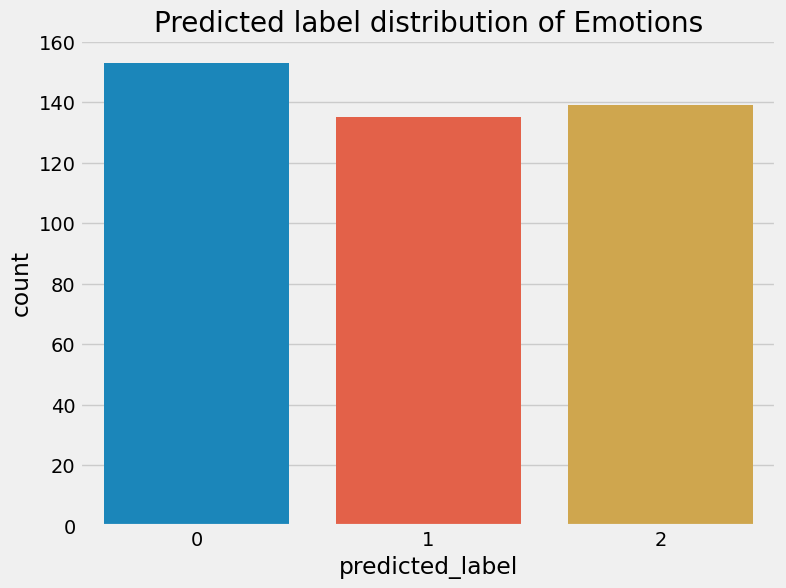

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already computed and stored the 'pred1' variable containing the predicted labels

# Convert the 'pred1' NumPy array to a DataFrame with a new column 'predicted_label'
df_pred = pd.DataFrame({'predicted_label': pred1})

# Plot the predicted label distribution using Seaborn countplot
plt.figure(figsize=(8, 6))
plt.title("Predicted label distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='predicted_label', data=df_pred)
plt.show()


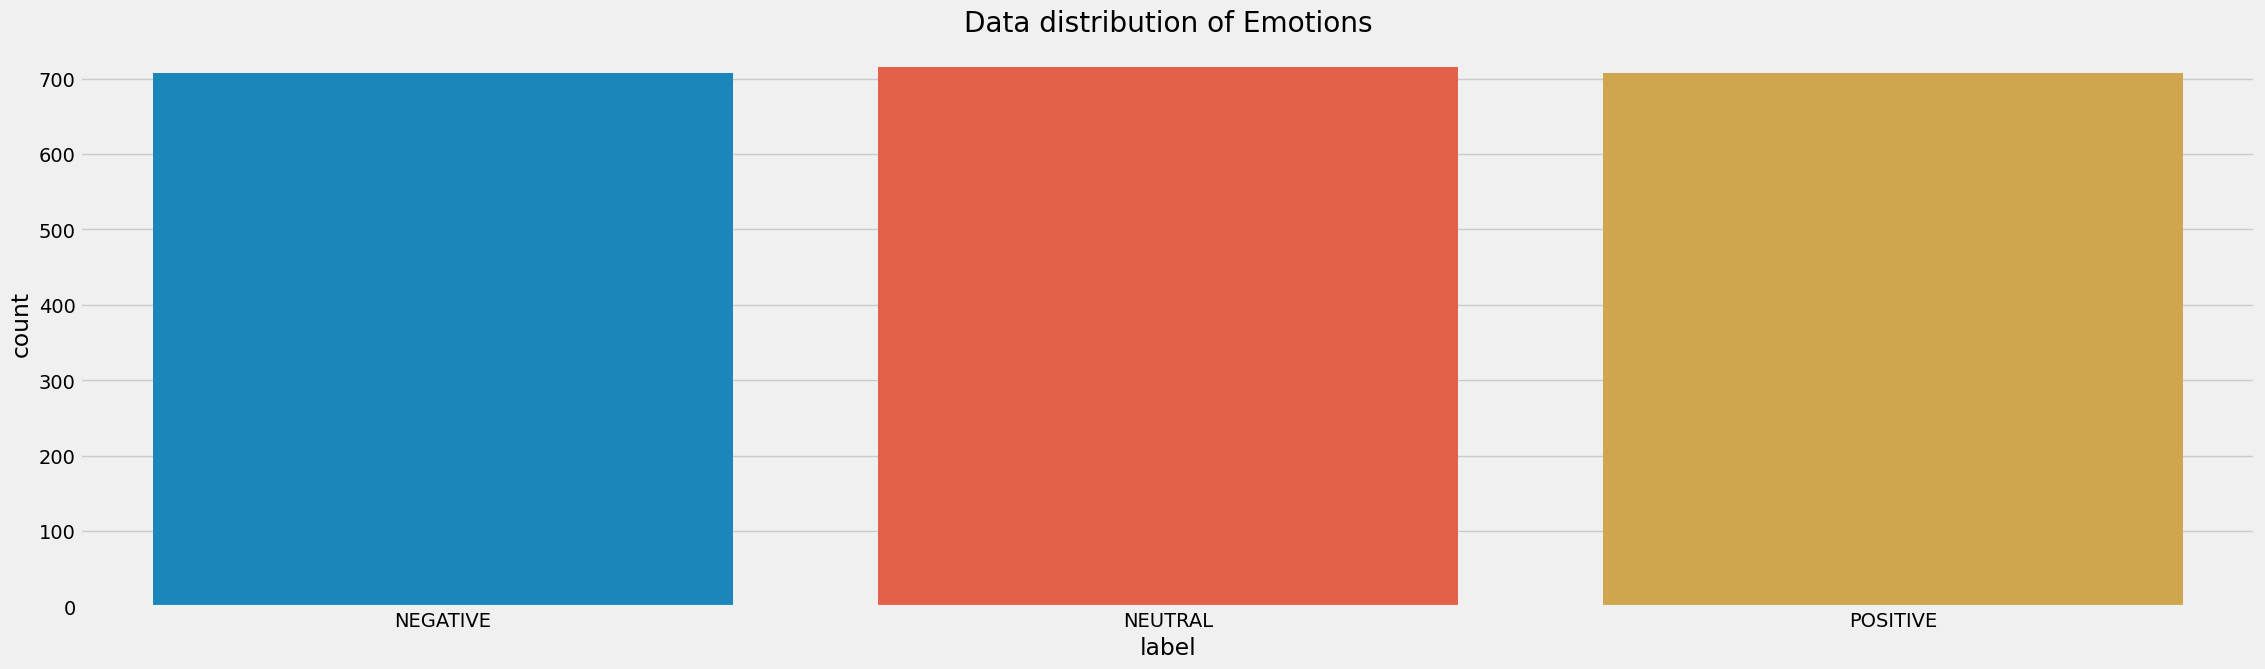

In [53]:
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

In [61]:
from nltk.translate.bleu_score import corpus_bleu

# Read the TXT file and split it into lines (each line contains one reference and one predicted sentence)
with open('/content/drive/MyDrive/result.txt', 'r') as file:
    lines = file.readlines()

# Extract the reference and predicted sentences from the lines
reference_dataset = []
predicted_dataset = []

for line in lines:
    elements = line.strip().split('\t')
    if len(elements) == 2:
        reference, predicted = elements
        reference_dataset.append(reference)
        predicted_dataset.append(predicted)
    else:
        # Handle cases where a line may not contain both reference and predicted sentences
        print("Skipping line:", line.strip())

# Convert the reference and predicted datasets into lists of lists of tokens (words or subwords)
reference_tokens = [[sentence.split()] for sentence in reference_dataset]
predicted_tokens = [sentence.split() for sentence in predicted_dataset]

# Calculate BLEU-1, BLEU-2, and BLEU-4 scores for the entire datasets
bleu_1_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(1, 0, 0, 0))
bleu_2_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.5, 0.5, 0, 0))
bleu_3_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.25, 0.25, 0.25, 0))
bleu_4_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print the BLEU scores
print("BLEU-1 score:", bleu_1_score)
print("BLEU-2 score:", bleu_2_score)
print("BLEU-3 score:", bleu_3_score)
print("BLEU-4 score:", bleu_4_score)


Streaming output truncated to the last 5000 lines.
Skipping line: target string: Starts out mediocre, spirals downward, and thuds to the bottom of the pool with an utterly incompetent conclusion.
Skipping line: predicted string: . at in, butalling out, and endsunders into a point of the earth. a occasional un result.
Skipping line: ################################################
Skipping line: 
Skipping line: 
Skipping line: target string: The sort of movie that gives tastelessness a bad rap.
Skipping line: predicted string:  film of thing that would youeful, to sense name.
Skipping line: ################################################
Skipping line: 
Skipping line: 
Skipping line: target string: Its engaging simplicity is driven by appealing leads.
Skipping line: predicted string:  name and and a by its to and
Skipping line: ################################################
Skipping line: 
Skipping line: 
Skipping line: target string: Fans of the TV series will be disappointed, and e

ZeroDivisionError: ignored

In [62]:
print("Contents of list_of_references:")
for sentences in reference_dataset:
    print(sentences)

print("\nContents of hypotheses:")
for sentences in predicted_dataset:
    print(sentences)

# Check if the lists are not empty
if not reference_dataset or not predicted_dataset:
    print("\nError: Either list_of_references or hypotheses is empty.")
    exit()

# Check if list_of_references is a list of lists
if not all(isinstance(refs, list) for refs in reference_dataset):
    print("\nError: list_of_references is not a list of lists.")
    exit()

# Check if hypotheses is a list of lists
if not all(isinstance(hypothesis, list) for hypothesis in predicted_dataset):
    print("\nError: hypotheses is not a list of lists.")
    exit()

Contents of list_of_references:

Contents of hypotheses:

Error: Either list_of_references or hypotheses is empty.


In [3]:
from nltk.translate.bleu_score import sentence_bleu

# Assuming you have the list_of_references and hypotheses as valid lists of lists of tokens (words or subwords)

# Calculate ROUGE-1 score for the entire dataset
rouge_1_score = 0.0
num_samples = len(reference_dataset)

for references, hypothesis in zip(reference_dataset, predicted_dataset):
    reference_tokens = [reference.split() for reference in reference_dataset]
    hypothesis_tokens = hypothesis.split()

    # Calculate ROUGE-1 score for each sample
    rouge_1_score += sentence_bleu(reference_tokens, hypothesis_tokens, weights=(1, 0, 0))

# Average ROUGE-1 score over all samples
rouge_1_score /= num_samples

# Print the ROUGE-1 score
print("ROUGE-1 score:", rouge_1_score)


NameError: ignored